<a href="https://colab.research.google.com/github/rdgreene/CNN-Workshop/blob/master/CNN_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from skimage import io, transform

!git clone https://ronangreene@bitbucket.org/ronangreene/cats_vs_dogs.git # clone repository with cats and dogs images
!unzip cats_vs_dogs/data.zip # unzip data in clones repo
!rm -r cats_vs_dogs # remove zipped data



# # get names of all cats and dogs images
# cats = os.listdir('data/cats')
# dogs = os.listdir('data/dogs')

In [0]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

In [3]:
%tensorflow_version 2.x
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

keras.__version__

TensorFlow 2.x selected.


'2.2.4-tf'

In [0]:
target_size = 128

In [72]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(target_size, target_size),
    batch_size=32,
    class_mode='binary'
    )

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [71]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
    )

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 12, 12, 128)     

In [0]:
import time

In [0]:
tic = time.time()

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=10)

toc = time.time()
print((toc-tic)/60)

Epoch 1/20
10/10 [==============================] - 19s 2s/step - loss: 0.7292 - acc: 0.4594 - val_loss: 0.6978 - val_acc: 0.4966
Epoch 2/20
10/10 [==============================] - 18s 2s/step - loss: 0.6949 - acc: 0.5594 - val_loss: 0.6936 - val_acc: 0.4966
Epoch 3/20
10/10 [==============================] - 17s 2s/step - loss: 0.6956 - acc: 0.5125 - val_loss: 0.6914 - val_acc: 0.5000
Epoch 4/20
10/10 [==============================] - 18s 2s/step - loss: 0.6931 - acc: 0.5125 - val_loss: 0.6927 - val_acc: 0.5203
Epoch 5/20
10/10 [==============================] - 18s 2s/step - loss: 0.6970 - acc: 0.5281 - val_loss: 0.6937 - val_acc: 0.4831
Epoch 6/20
10/10 [==============================] - 18s 2s/step - loss: 0.6932 - acc: 0.5250 - val_loss: 0.6931 - val_acc: 0.5068
Epoch 7/20
 2/10 [=====>........................] - ETA: 10s - loss: 0.6939 - acc: 0.4531

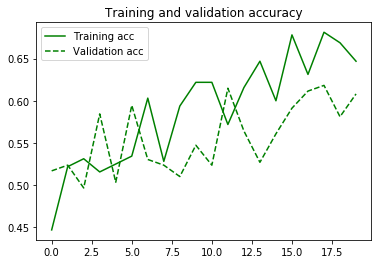

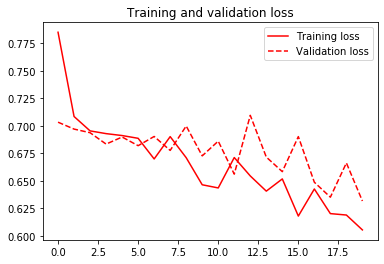

In [60]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'g--', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# adding droput and image augmentation

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(target_size, target_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
    )

model.summary()

### DEV AREA

In [39]:
import time
time.time()

1572782293.2272391

In [11]:

ls

cats_test  cats_train  cats_val  dogs_test  dogs_train	dogs_val


In [0]:
from skimage import io, transform
import numpy as np
import time

tic = time.time()

data = []
test_data = []

# get train and test data for cats
# for i, file in enumerate(cats):
#     try:
#         myimage = io.imread('data/cats/' + file).astype(np.float32)/255
#         myimage = transform.resize(myimage, (64, 64, 3))
#         if i < 950:
#           data.append((myimage, 1))
#         else:
#           test_data.append((myimage, 1))
#     except:
#         pass

# get train and test data for dogs
for i, file in enumerate(dogs):
    try:
        myimage = io.imread('data/dogs/' + file).astype(np.float32)/255
        myimage = transform.resize(myimage, (64, 64, 3))
        if i < 950:
          data.append((myimage, 1))
        else:
          test_data.append((myimage, 1))
    except:
        pass

print(time.time() - tic)



In [0]:
# build neural network

from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))